<a href="https://colab.research.google.com/github/lqcgithub/MiningofMassiveDatasets/blob/main/Pyspark_Machine_Learing_MLlib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pyspark

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('ml-bank').getOrCreate()
df = spark.read.csv('/content/drive/MyDrive/sample-datasets/bank.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



### Pandas dataframe is prettier than Spark DataFrame.show()

In [4]:
import pandas as pd
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
age,59,56,41,55,54
job,admin.,admin.,technician,services,admin.
marital,married,married,married,married,married
education,secondary,secondary,secondary,secondary,tertiary
default,no,no,no,no,no
balance,2343,45,1270,2476,184
housing,yes,no,yes,yes,no
loan,no,no,no,no,no
contact,unknown,unknown,unknown,unknown,unknown
day,5,5,5,5,5


In [5]:
df.groupby('deposit').count().toPandas()

,deposit,count
0,no,5873
1,yes,5289


### Summary statistics for numeric variables

In [6]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,11162,41.231947679627304,11.913369192215518,18,95
balance,11162,1528.5385235620856,3225.413325946149,-6847,81204
day,11162,15.658036194230425,8.420739541006462,1,31
duration,11162,371.99381831213043,347.12838571630687,2,3881
campaign,11162,2.508421429851281,2.7220771816614824,1,63
pdays,11162,51.33040673714388,108.75828197197717,-1,854
previous,11162,0.8325568894463358,2.292007218670508,0,58


In [7]:
df = df.select('age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit')
cols = df.columns
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [8]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]

numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [9]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [10]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
label,1,1,1,1,1
features,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
age,59,56,41,55,54
job,admin.,admin.,technician,services,admin.
marital,married,married,married,married,married
education,secondary,secondary,secondary,secondary,tertiary
default,no,no,no,no,no
balance,2343,45,1270,2476,184
housing,yes,no,yes,yes,no
loan,no,no,no,no,no


In [11]:
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 7855
Test Dataset Count: 3307


In [12]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

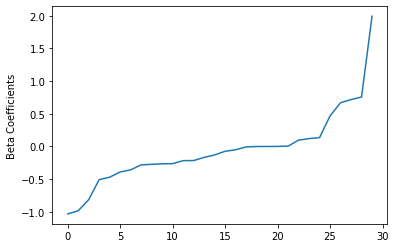

In [13]:
import matplotlib.pyplot as plt
import numpy as np

beta = np.sort(lrModel.coefficients)

plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

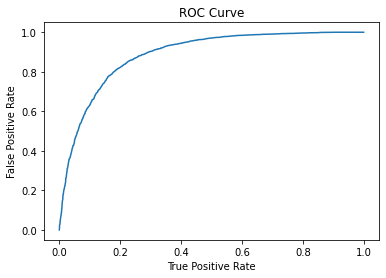

Training set areaUnderROC: 0.8865551189326405


In [14]:
trainingSummary = lrModel.summary

roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

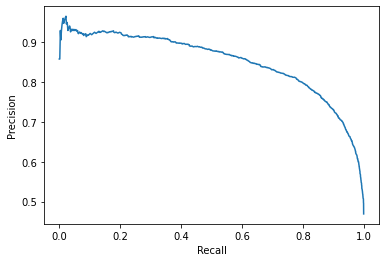

In [15]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

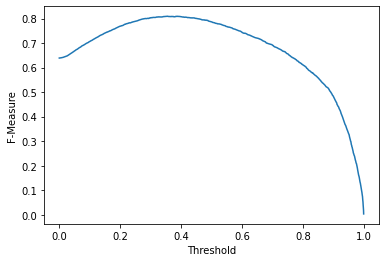

In [16]:
f = trainingSummary.fMeasureByThreshold.toPandas()
plt.plot(f['threshold'],f['F-Measure'])
plt.ylabel('F-Measure')
plt.xlabel('Threshold')
plt.show()

In [17]:
predictions = lrModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 33|management|  0.0|[1.93500470498079...|       0.0|[0.87380233100701...|
| 49|management|  0.0|[2.04809361205496...|       0.0|[0.88575484704982...|
| 52|management|  0.0|[-0.7002122133357...|       1.0|[0.33176517908283...|
| 53|management|  0.0|[1.03431610227357...|       0.0|[0.73775180622517...|
| 58|management|  0.0|[2.74273671692568...|       0.0|[0.93950183380104...|
| 32|management|  0.0|[1.25033004378244...|       0.0|[0.77735698810451...|
| 57|management|  0.0|[1.19540519867323...|       0.0|[0.76770638557283...|
| 52|management|  0.0|[3.26456982709641...|       0.0|[0.96319314409492...|
| 46|management|  0.0|[2.15036209979036...|       0.0|[0.89570260888977...|
| 31|management|  0.0|[1.47751802200862...|       0.0|[0.81419739986183...|
+---+-------

In [18]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8837112925002687


In [19]:
evaluator.getMetricName()

'areaUnderROC'

In [20]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())

cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

cvModel = cv.fit(train)
predictions = cvModel.transform(test)
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8833850995346151


In [21]:
evaluator.getMetricName()

'areaUnderROC'

In [22]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------+----------+--------------------+
|age|       job|label| rawPrediction|prediction|         probability|
+---+----------+-----+--------------+----------+--------------------+
| 33|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 49|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 52|management|  0.0|[520.0,1931.0]|       1.0|[0.21215830273357...|
| 53|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 58|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 32|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 57|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 52|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 46|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 31|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
+---+----------+-----+--------------+----------+--------------------+
only showing top 10 

In [23]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7808118726917547


In [24]:
evaluator.getMetricName()

'areaUnderROC'